In [84]:
#Imports

In [85]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score


In [86]:
test_df = pd.read_csv('test.csv')
train_df = pd.read_csv('train.csv')

In [87]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 750000 entries, 0 to 749999
Data columns (total 12 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   id                           750000 non-null  int64  
 1   Podcast_Name                 750000 non-null  object 
 2   Episode_Title                750000 non-null  object 
 3   Episode_Length_minutes       662907 non-null  float64
 4   Genre                        750000 non-null  object 
 5   Host_Popularity_percentage   750000 non-null  float64
 6   Publication_Day              750000 non-null  object 
 7   Publication_Time             750000 non-null  object 
 8   Guest_Popularity_percentage  603970 non-null  float64
 9   Number_of_Ads                749999 non-null  float64
 10  Episode_Sentiment            750000 non-null  object 
 11  Listening_Time_minutes       750000 non-null  float64
dtypes: float64(5), int64(1), object(6)
memory usage: 68.7+ MB


In [88]:
train_df.describe()

,id,Episode_Length_minutes,Host_Popularity_percentage,Guest_Popularity_percentage,Number_of_Ads,Listening_Time_minutes
count,750000.000000,662907.000000,750000.000000,603970.000000,749999.000000,750000.000000
mean,374999.500000,64.504738,59.859901,52.236449,1.348855,45.437406
std,216506.495284,32.969603,22.873098,28.451241,1.151130,27.138306
min,0.000000,0.000000,1.300000,0.000000,0.000000,0.000000
25%,187499.750000,35.730000,39.410000,28.380000,0.000000,23.178350
50%,374999.500000,63.840000,60.050000,53.580000,1.000000,43.379460
75%,562499.250000,94.070000,79.530000,76.600000,2.000000,64.811580
max,749999.000000,325.240000,119.460000,119.910000,103.910000,119.970000


In [89]:
train_df.isnull().sum()

id                                  0
Podcast_Name                        0
Episode_Title                       0
Episode_Length_minutes          87093
Genre                               0
Host_Popularity_percentage          0
Publication_Day                     0
Publication_Time                    0
Guest_Popularity_percentage    146030
Number_of_Ads                       1
Episode_Sentiment                   0
Listening_Time_minutes              0
dtype: int64

In [90]:
#Handling the missing values and preparing data

In [91]:
X = train_df.drop('Listening_Time_minutes', axis=1)
y = train_df['Listening_Time_minutes']

In [92]:
# After wasting several minutes trying to train the models using the full dataset, i decided to take a smaller sample for tuning before going to full scale.

In [93]:
X_sample, _, y_sample, _ = train_test_split(X, y, test_size=0.8, random_state=42)

In [94]:
X_train, X_val, y_train, y_val = train_test_split(X_sample, y_sample, test_size=0.2, random_state=42)

print(f"Sample training size: {X_train.shape}")

Sample training size: (120000, 11)


In [95]:
X_train['Number_of_Ads'] = X_train['Number_of_Ads'].fillna(X_train['Number_of_Ads'].median())
X_val['Number_of_Ads'] = X_val['Number_of_Ads'].fillna(X_val['Number_of_Ads'].median())


In [96]:
# I believe podcast names were slowing down the fitting of the model, since it likely has too many categories

In [97]:
categorical_cols = ['Genre', 'Publication_Day', 'Publication_Time', 'Episode_Sentiment']
numerical_cols = ['Episode_Length_minutes', 'Host_Popularity_percentage', 'Guest_Popularity_percentage', 'Number_of_Ads']

In [98]:
X_train['Guest_Popularity_Missing'] = X_train['Guest_Popularity_percentage'].isna().astype(int)
X_val['Guest_Popularity_Missing'] = X_val['Guest_Popularity_percentage'].isna().astype(int)
X_train['Episode_Length_Missing'] = X_train['Episode_Length_minutes'].isna().astype(int)
X_val['Episode_Length_Missing'] = X_val['Episode_Length_minutes'].isna().astype(int)


In [99]:
numerical_cols.extend(['Guest_Popularity_Missing', 'Episode_Length_Missing'])


In [100]:
# Drop unnecessary columns

In [101]:
drop_cols = ['id', 'Episode_Title', 'Podcast_Name']
X_train = X_train.drop(columns=drop_cols)
X_val = X_val.drop(columns=drop_cols)

In [102]:
#Creating and combining processing steps

In [103]:
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

In [104]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

In [105]:
#Creating and evaluating simplified models

In [106]:
rf_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(n_estimators=50, max_depth=15, random_state=42))
])

In [107]:
print("Training Random Forest model...")
rf_model.fit(X_train, y_train)
print("Random Forest model trained!")

Training Random Forest model...
Random Forest model trained!


In [108]:
y_pred_rf = rf_model.predict(X_val)


In [109]:
rf_rmse = np.sqrt(mean_squared_error(y_val, y_pred_rf))
rf_r2 = r2_score(y_val, y_pred_rf)

print(f"Random Forest RMSE: {rf_rmse:.4f}")
print(f"Random Forest R²: {rf_r2:.4f}")

Random Forest RMSE: 13.1548
Random Forest R²: 0.7650


In [110]:
lr_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

In [111]:
print("Training Linear Regression model...")
lr_model.fit(X_train, y_train)
print("Linear Regression model trained!")

Training Linear Regression model...
Linear Regression model trained!


In [112]:
y_pred_lr = lr_model.predict(X_val)

In [113]:
lr_rmse = np.sqrt(mean_squared_error(y_val, y_pred_lr))
lr_r2 = r2_score(y_val, y_pred_lr)

print(f"Linear Regression RMSE: {lr_rmse:.4f}")
print(f"Linear Regression R²: {lr_r2:.4f}")

Linear Regression RMSE: 13.3565
Linear Regression R²: 0.7578


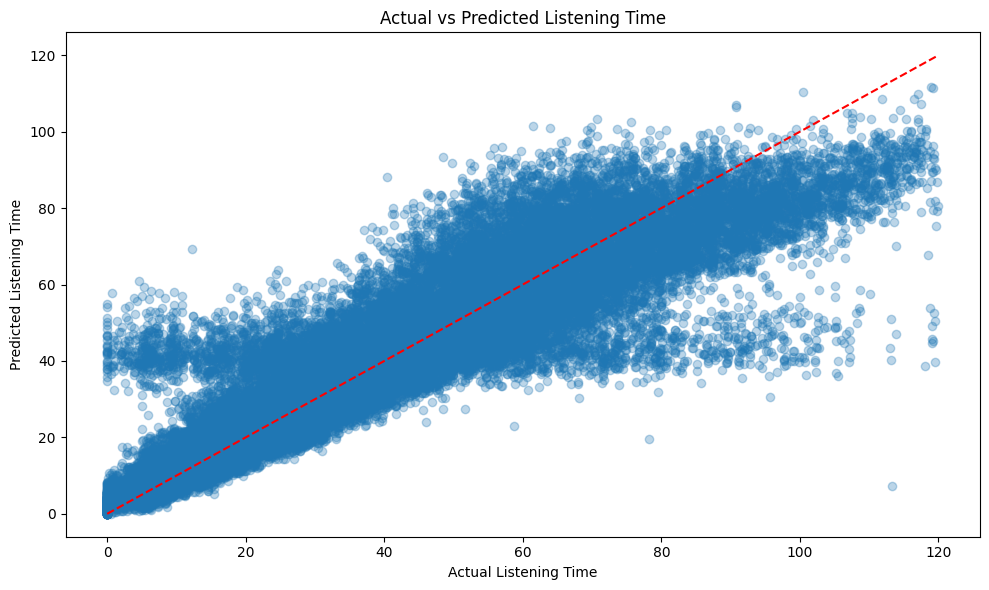

In [114]:
plt.figure(figsize=(10, 6))
plt.scatter(y_val, y_pred_rf if rf_r2 > lr_r2 else y_pred_lr, alpha=0.3)
plt.plot([0, 120], [0, 120], 'r--')
plt.xlabel('Actual Listening Time')
plt.ylabel('Predicted Listening Time')
plt.title('Actual vs Predicted Listening Time')
plt.tight_layout()
plt.show()

In [115]:
# Get feature names after preprocessing
preprocessor = rf_model.named_steps['preprocessor']
feature_names = []

In [116]:
# Get numerical feature names
num_features = numerical_cols
for feature in num_features:
    feature_names.append(feature)

In [117]:
#Analyzing feature importance from the Random Forest model
X_train_processed = rf_model.named_steps['preprocessor'].transform(X_train)

In [118]:
# Get feature importances
importances = rf_model.named_steps['regressor'].feature_importances_

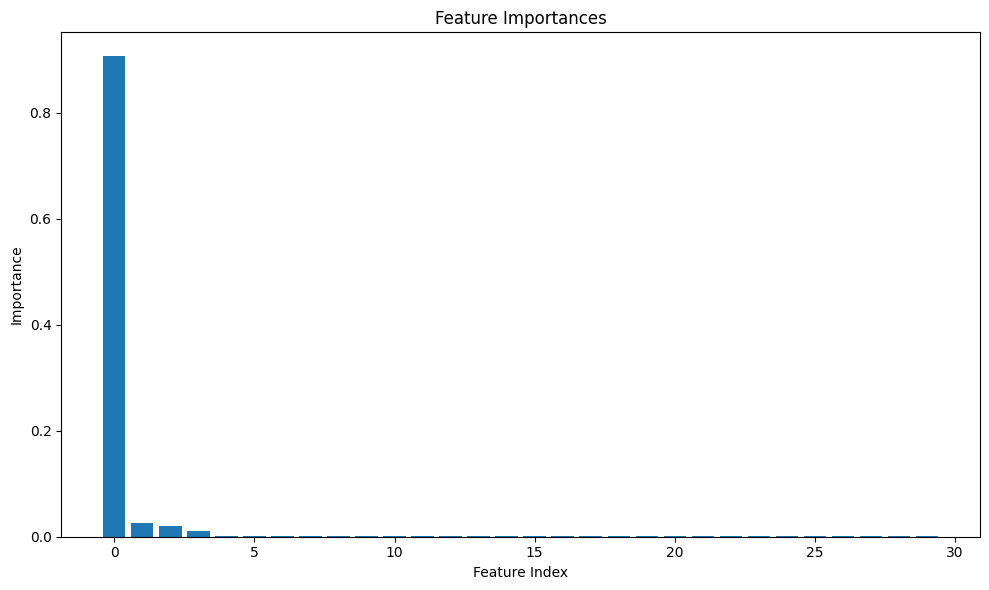

In [119]:
plt.figure(figsize=(10, 6))
plt.bar(range(len(importances)), importances)
plt.title('Feature Importances')
plt.xlabel('Feature Index')
plt.ylabel('Importance')
plt.tight_layout()
plt.show()

In [120]:
#trying Gradient Boosting as another model
from sklearn.ensemble import GradientBoostingRegressor

In [121]:
gb_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42))
])

In [122]:
print("Training Gradient Boosting model...")
gb_model.fit(X_train, y_train)
print("Gradient Boosting model trained!")


Training Gradient Boosting model...
Gradient Boosting model trained!


In [123]:
y_pred_gb = gb_model.predict(X_val)

In [124]:
gb_rmse = np.sqrt(mean_squared_error(y_val, y_pred_gb))
gb_r2 = r2_score(y_val, y_pred_gb)

In [125]:

print(f"Gradient Boosting RMSE: {gb_rmse:.4f}")
print(f"Gradient Boosting R²: {gb_r2:.4f}")

Gradient Boosting RMSE: 13.1416
Gradient Boosting R²: 0.7655


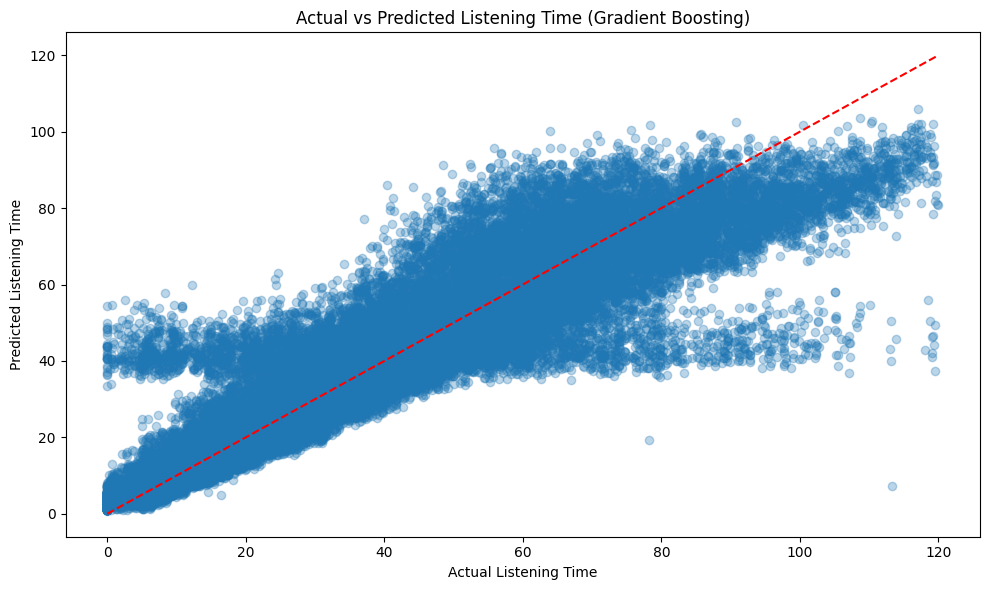

In [126]:
# Let's also analyze the relationship between actual and predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_val, y_pred_gb, alpha=0.3)
plt.plot([0, 120], [0, 120], 'r--')
plt.xlabel('Actual Listening Time')
plt.ylabel('Predicted Listening Time')
plt.title('Actual vs Predicted Listening Time (Gradient Boosting)')
plt.tight_layout()
plt.show()


In [127]:
# Let's create a function to prepare new data for prediction
def prepare_data_for_prediction(df):
    """Prepares new data for prediction using our best model"""
    # Make a copy to avoid modifying the original
    df_copy = df.copy()
    
    # Handle missing values in Number_of_Ads
    df_copy['Number_of_Ads'] = df_copy['Number_of_Ads'].fillna(df_copy['Number_of_Ads'].median())
    
    # Create missing flags
    df_copy['Guest_Popularity_Missing'] = df_copy['Guest_Popularity_percentage'].isna().astype(int)
    df_copy['Episode_Length_Missing'] = df_copy['Episode_Length_minutes'].isna().astype(int)
    
    # Drop unnecessary columns
    if 'id' in df_copy.columns:
        df_copy = df_copy.drop(columns=['id'])
    if 'Episode_Title' in df_copy.columns:
        df_copy = df_copy.drop(columns=['Episode_Title'])
    if 'Podcast_Name' in df_copy.columns:
        df_copy = df_copy.drop(columns=['Podcast_Name'])
    
    return df_copy

# Choose the best model based on R²
best_model = rf_model if rf_r2 > gb_r2 else gb_model
best_model_name = "Random Forest" if rf_r2 > gb_r2 else "Gradient Boosting"
print(f"Best model: {best_model_name}")

# Function to make predictions on new data
def predict_listening_time(df, model):
    """Makes predictions on new data using the trained model"""
    # Prepare the data
    prepared_df = prepare_data_for_prediction(df)
    
    # Make predictions
    predictions = model.predict(prepared_df)
    
    return predictions

# Example of how to use the prediction function
print("\nExample of how to predict on new data:")
print("test_df_prepared = prepare_data_for_prediction(test_df)")
print("predictions = best_model.predict(test_df_prepared)")


Best model: Gradient Boosting

Example of how to predict on new data:
test_df_prepared = prepare_data_for_prediction(test_df)
predictions = best_model.predict(test_df_prepared)


In [128]:
X_train_processed = preprocessor.fit_transform(X_train)

In [129]:
# Create a simpler Random Forest model directly on processed features
direct_rf = RandomForestRegressor(n_estimators=50, max_depth=15, random_state=42)
direct_rf.fit(X_train_processed, y_train)

RandomForestRegressor(max_depth=15, n_estimators=50, random_state=42)

In [130]:
# Get feature importances
importances = direct_rf.feature_importances_

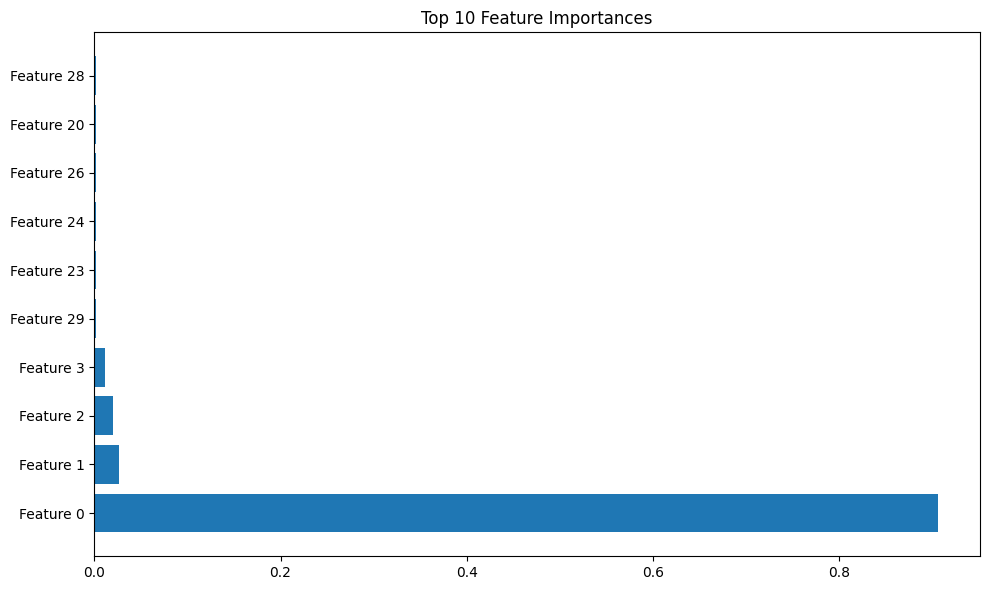

Top 10 most important feature indices: [ 0  1  2  3 29 23 24 26 20 28]


In [131]:
# Sort and get top 10 feature indices
top_indices = importances.argsort()[-10:][::-1]
top_importances = importances[top_indices]

plt.figure(figsize=(10, 6))
plt.barh(range(len(top_indices)), top_importances)
plt.yticks(range(len(top_indices)), [f"Feature {i}" for i in top_indices])
plt.title('Top 10 Feature Importances')
plt.tight_layout()
plt.show()
print(f"Top 10 most important feature indices: {top_indices}")

In [132]:
# Finalizing the model with full dataset

In [133]:
X = train_df.drop('Listening_Time_minutes', axis=1)
y = train_df['Listening_Time_minutes']

In [134]:
X['Number_of_Ads'] = X['Number_of_Ads'].fillna(X['Number_of_Ads'].median())

In [135]:
categorical_cols = ['Genre', 'Publication_Day', 'Publication_Time', 'Episode_Sentiment']
numerical_cols = ['Episode_Length_minutes', 'Host_Popularity_percentage', 'Guest_Popularity_percentage', 'Number_of_Ads']


In [136]:
X['Guest_Popularity_Missing'] = X['Guest_Popularity_percentage'].isna().astype(int)
X['Episode_Length_Missing'] = X['Episode_Length_minutes'].isna().astype(int)

In [137]:
numerical_cols.extend(['Guest_Popularity_Missing', 'Episode_Length_Missing'])

In [138]:
drop_cols = ['id', 'Episode_Title', 'Podcast_Name']
X = X.drop(columns=drop_cols)

In [139]:
# Create preprocessing steps
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])


In [140]:
# Create the final Gradient Boosting model (since it performed best)
final_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42))
])


In [141]:
# Fit the model on the entire training dataset
print("Training final model on full dataset...")
final_model.fit(X, y)
print("Final model trained!")

Training final model on full dataset...
Final model trained!


In [142]:
# Define a function to prepare new data for prediction
def prepare_new_data(df):
    """Prepares new data for prediction"""
    # Make a copy to avoid modifying the original
    df_copy = df.copy()
    
    # Handle missing values in Number_of_Ads
    df_copy['Number_of_Ads'] = df_copy['Number_of_Ads'].fillna(df_copy['Number_of_Ads'].median())
    
    # Create missing flags
    df_copy['Guest_Popularity_Missing'] = df_copy['Guest_Popularity_percentage'].isna().astype(int)
    df_copy['Episode_Length_Missing'] = df_copy['Episode_Length_minutes'].isna().astype(int)
    
    # Drop unnecessary columns if they exist
    cols_to_drop = ['id', 'Episode_Title', 'Podcast_Name']
    for col in cols_to_drop:
        if col in df_copy.columns:
            df_copy = df_copy.drop(columns=[col])
    
    return df_copy


In [143]:
# Function to make predictions on new data
def predict_listening_time(new_data, model=final_model):
    """Makes predictions on new data using the trained model"""
    # Prepare the data
    prepared_data = prepare_new_data(new_data)
    
    # Make predictions
    predictions = model.predict(prepared_data)
    
    return predictions


In [144]:
prepared_test_df = prepare_new_data(test_df)

# Now we can make predictions using our trained model
predictions = final_model.predict(prepared_test_df)

# Add these predictions to your test dataframe
test_df['Predicted_Listening_Time'] = predictions

# Display the first few rows to verify the predictions were added
print(test_df[['Episode_Length_minutes', 'Genre', 'Host_Popularity_percentage', 'Predicted_Listening_Time']].head())



   Episode_Length_minutes      Genre  Host_Popularity_percentage  \
0                   78.96  Education                       38.11   
1                   27.87      Music                       71.29   
2                   69.10     Comedy                       67.89   
3                  115.39     Comedy                       23.40   
4                   72.32  Lifestyle                       58.10   

   Predicted_Listening_Time  
0                 56.204014  
1                 18.217515  
2                 49.046730  
3                 81.016085  
4                 48.749465  


In [145]:
test_df

,id,Podcast_Name,Episode_Title,Episode_Length_minutes,Genre,Host_Popularity_percentage,Publication_Day,Publication_Time,Guest_Popularity_percentage,Number_of_Ads,Episode_Sentiment,Predicted_Listening_Time
0,750000,Educational Nuggets,Episode 73,78.96,Education,38.11,Saturday,Evening,53.33,1.0,Neutral,56.204014
1,750001,Sound Waves,Episode 23,27.87,Music,71.29,Sunday,Morning,NaN,0.0,Neutral,18.217515
2,750002,Joke Junction,Episode 11,69.10,Comedy,67.89,Friday,Evening,97.51,0.0,Positive,49.046730
3,750003,Comedy Corner,Episode 73,115.39,Comedy,23.40,Sunday,Morning,51.75,2.0,Positive,81.016085
4,750004,Life Lessons,Episode 50,72.32,Lifestyle,58.10,Wednesday,Morning,11.30,2.0,Neutral,48.749465
...,...,...,...,...,...,...,...,...,...,...,...,...
249995,999995,Mind & Body,Episode 100,21.05,Health,65.77,Saturday,Evening,96.40,3.0,Negative,11.744646
249996,999996,Joke Junction,Episode 85,85.50,Comedy,41.47,Saturday,Night,30.52,2.0,Negative,58.367461
249997,999997,Joke Junction,Episode 63,12.11,Comedy,25.92,Thursday,Evening,73.69,1.0,Neutral,7.117802
249998,999998,Market Masters,Episode 46,113.46,Business,43.47,Friday,Night,93.59,3.0,Positive,73.670843


In [146]:
# Saving for submission

In [147]:
submission_df = test_df[['id', 'Predicted_Listening_Time']].copy()
submission_df.rename(columns={'Predicted_Listening_Time': 'Listening_Time_minutes'}, inplace=True)

# Save to CSV
submission_df.to_csv('submission.csv', index=False)


In [148]:
subs = pd.read_csv('submission.csv')

In [149]:
subs

,id,Listening_Time_minutes
0,750000,56.204014
1,750001,18.217515
2,750002,49.046730
3,750003,81.016085
4,750004,48.749465
...,...,...
249995,999995,11.744646
249996,999996,58.367461
249997,999997,7.117802
249998,999998,73.670843
